If a generic attention mechiansm didn't work, 
- Can we investigate the similarity of activation?

In [1]:
# from AttentionModule import Conv2d_Attn

import torch
from torch import nn
from torchvision import models, datasets, transforms
import torch.optim as optim
from torch.autograd import Variable
import torchvision
import torchvision.transforms as transforms

import re
import numpy as np

In [2]:
resnet50 = models.resnet152(pretrained=True)

In [3]:
batch_size = 32
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
transform = transforms.Compose(
    [transforms.ToTensor(),
     normalize])

trainset = torchvision.datasets.ImageFolder(root='../data/train', transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

In [4]:
batch, labels = next(iter(trainloader))

In [5]:
blks = list(resnet50.children())

In [6]:
list(map(type, blks))

[torch.nn.modules.conv.Conv2d,
 torch.nn.modules.batchnorm.BatchNorm2d,
 torch.nn.modules.activation.ReLU,
 torch.nn.modules.pooling.MaxPool2d,
 torch.nn.modules.container.Sequential,
 torch.nn.modules.container.Sequential,
 torch.nn.modules.container.Sequential,
 torch.nn.modules.container.Sequential,
 torch.nn.modules.pooling.AvgPool2d,
 torch.nn.modules.linear.Linear]

In [7]:
len(blks)

10

In [8]:
resnet50 = resnet50.eval().cuda()

In [9]:
outs = []
out = Variable(batch).cuda()

In [10]:
batch.size()

torch.Size([32, 3, 224, 224])

In [11]:
def linear_pre_hook(out):
    return out.view(out.size(0), -1)

In [12]:
for layer in blks:
    print(type(layer))
    if isinstance(layer, torch.nn.modules.linear.Linear):
        out = out.view(out.size(0), -1)
    out = layer(out)
    outs.append(out)

<class 'torch.nn.modules.conv.Conv2d'>
<class 'torch.nn.modules.batchnorm.BatchNorm2d'>
<class 'torch.nn.modules.activation.ReLU'>
<class 'torch.nn.modules.pooling.MaxPool2d'>
<class 'torch.nn.modules.container.Sequential'>
<class 'torch.nn.modules.container.Sequential'>
<class 'torch.nn.modules.container.Sequential'>
<class 'torch.nn.modules.container.Sequential'>
<class 'torch.nn.modules.pooling.AvgPool2d'>
<class 'torch.nn.modules.linear.Linear'>


In [13]:
avg_pool = outs[-2].squeeze().cpu().data.numpy()

In [14]:
linear = outs[-1].squeeze().cpu().data.numpy()

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

In [16]:
avg_pool.min(), avg_pool.max()

(0.0, 7.9371424)

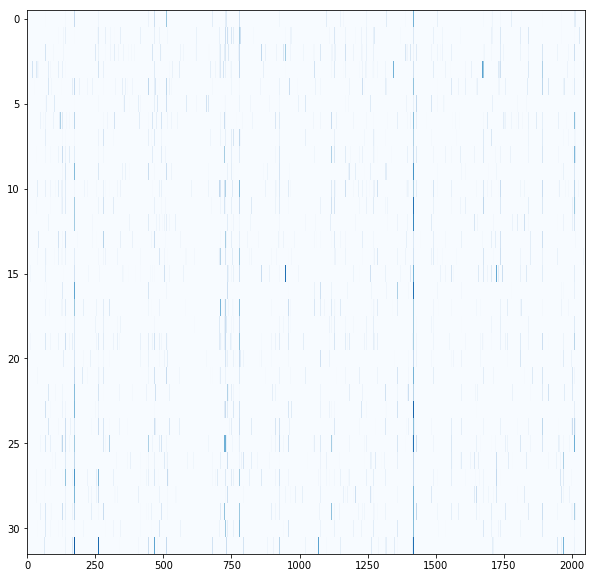

In [22]:
plt.figure(figsize=(10,10))
plt.imshow(avg_pool.clip(min=1)*2, aspect='auto', cmap='Blues')

In [24]:
linear.min()

-7.9313936

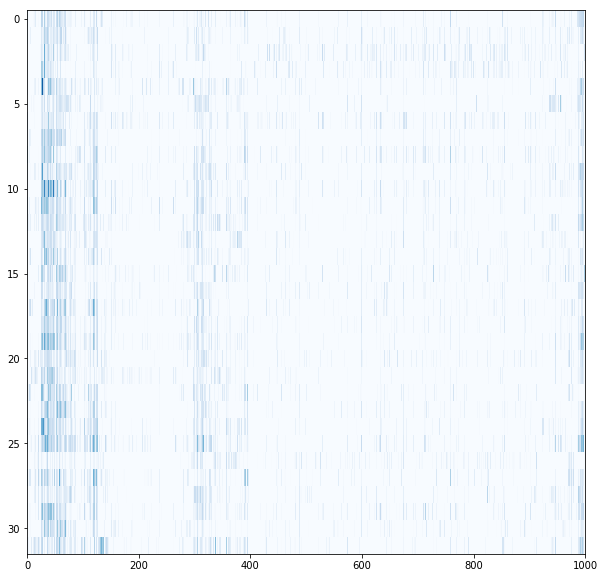

In [23]:
plt.figure(figsize=(10,10))
plt.imshow(linear.clip(1)*2, aspect='auto', cmap='Blues')

In [26]:
resnet50.fc.weight

Parameter containing:
-3.4428e-02 -3.9663e-02  1.4842e-03  ...  -3.3885e-02  3.5510e-03 -1.2589e-02
-4.0105e-03  1.1388e-03  1.4244e-02  ...  -2.2423e-02  1.0604e-02  8.3913e-04
 2.3130e-01 -1.6311e-02 -2.3313e-03  ...  -1.4265e-02 -2.5016e-02 -1.0045e-02
                ...                   ⋱                   ...                
-2.5180e-02 -1.1840e-02  1.7751e-01  ...  -1.5605e-02  1.4124e-01  1.4077e-02
 4.3309e-02  2.5399e-02  2.2576e-02  ...   1.9447e-03 -1.6007e-02 -3.8806e-02
-3.6419e-02  3.6677e-02 -3.6853e-02  ...  -9.8947e-03 -2.1388e-03 -1.1951e-02
[torch.cuda.FloatTensor of size 1000x2048 (GPU 0)]

In [27]:
resnet50.fc.bias

Parameter containing:
1.00000e-02 *
 -1.2052
 -0.9444
 -1.5197
    ⋮   
 -2.1055
  0.7286
  0.6289
[torch.cuda.FloatTensor of size 1000 (GPU 0)]

In [80]:
outs[-3].shape

torch.Size([32, 2048, 7, 7])

In [124]:
avg = outs[-2]

In [126]:
clipped = avg.data.cpu().numpy().clip(1)
clipped[clipped == 1] = 0

In [127]:
clipped *= 2

In [128]:
avg.data = torch.Tensor(clipped).cuda()

In [130]:
clp_res = blks[-1](linear_pre_hook(avg))

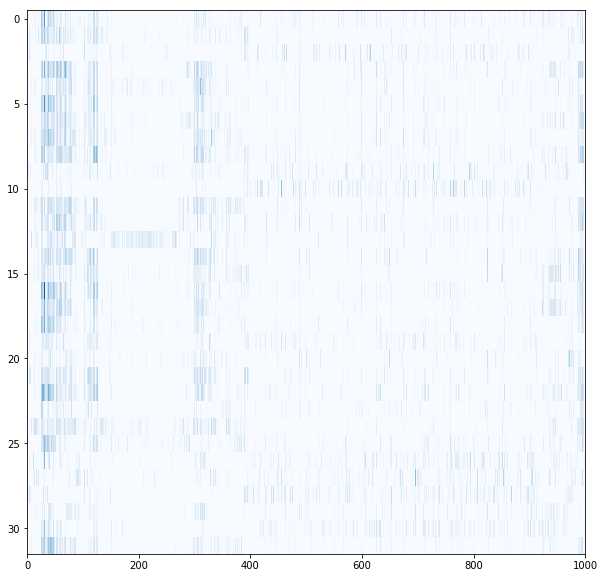

In [131]:
clp_res = clp_res.data.cpu().numpy()
plt.figure(figsize=(10,10))
plt.imshow(linear.clip(1), aspect='auto', cmap='Blues')